In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("AirQualityUCI.csv")
df.head()
df = df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1)
null_data = df[df.isnull().any(axis=1)]
df = df.dropna()
df = df.replace(-200, np.nan)
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
h = df['Time'].tolist()
l=[]
for i in range(len(h)):
    l.append(h[i].split(":")[0])
df['hour']=l
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
cols=["year","month","day","hour"]
df['date'] = df[cols].apply(lambda x: '/'.join(x.values.astype(str)), axis="columns")
df['date']=pd.to_datetime(df['date'])
del df['Date']
del df['Time']
df.set_index('date', inplace=True)
del df['NMHC(GT)']

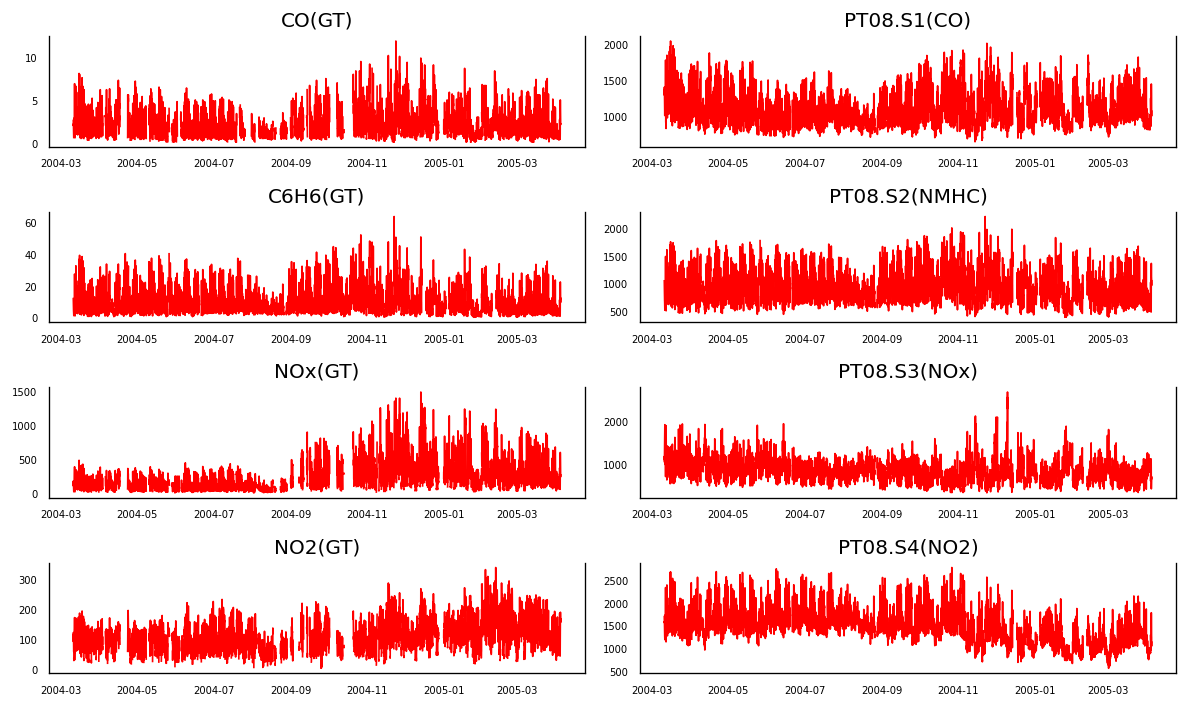

In [3]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [4]:
df['CO(GT)'] = df['CO(GT)'].ewm(halflife=4).mean()
df['PT08.S1(CO)'] = df['PT08.S1(CO)'].ewm(halflife=4).mean()
df['C6H6(GT)'] = df['C6H6(GT)'].ewm(halflife=4).mean()
df['PT08.S2(NMHC)'] = df['PT08.S2(NMHC)'].ewm(halflife=4).mean()
df['NOx(GT)'] = df['NOx(GT)'].ewm(halflife=4).mean()
df['PT08.S3(NOx)'] = df['PT08.S3(NOx)'].ewm(halflife=4).mean()
df['NO2(GT)'] = df['NO2(GT)'].ewm(halflife=4).mean()
df['PT08.S4(NO2)'] = df['PT08.S4(NO2)'].ewm(halflife=4).mean()
df['PT08.S5(O3)'] = df['PT08.S5(O3)'].ewm(halflife=4).mean()
df['T'] = df['T'].ewm(halflife=4).mean()
df['RH'] = df['RH'].ewm(halflife=4).mean()
df['AH'] = df['AH'].ewm(halflife=4).mean()

In [5]:
df.isnull().sum()

CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
hour             0
year             0
month            0
day              0
dtype: int64

In [6]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=48).mean()
    movingSTD = timeseries.rolling(window=48).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [7]:
df.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day
date,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,2.600000,1360.000000,11.900000,1046.000000,166.000000,1056.000000,113.000000,1692.000000,1268.000000,13.600000,48.900000,0.757800,18,2004,3,10
2004-03-10 19:00:00,2.274072,1323.061474,10.541966,996.567561,131.777542,1120.099207,101.592514,1619.752589,1107.208769,13.437036,48.248144,0.740254,19,2004,3,10
2004-03-10 20:00:00,2.245001,1354.042018,9.936800,973.974355,131.472385,1127.909555,106.462008,1594.339517,1094.175517,12.833804,50.505541,0.744158,20,2004,3,10
2004-03-10 21:00:00,2.230682,1361.029206,9.702345,965.709129,144.368562,1116.482877,111.406308,1591.049408,1128.804248,12.250275,53.526746,0.757695,21,2004,3,10
2004-03-10 22:00:00,2.057541,1336.588136,8.823209,930.100254,140.698509,1140.783366,112.667408,1563.308448,1123.641942,11.961944,55.194028,0.766234,22,2004,3,10


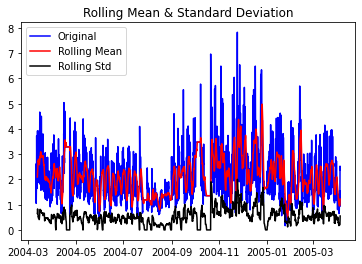

Results of Dickey Fuller Test:
Test Statistic                -9.846946e+00
p-value                        4.592785e-17
#Lags Used                     2.800000e+01
Number of Observations Used    9.328000e+03
Critical Value (1%)           -3.431051e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [8]:
test_stationarity(df['CO(GT)'])

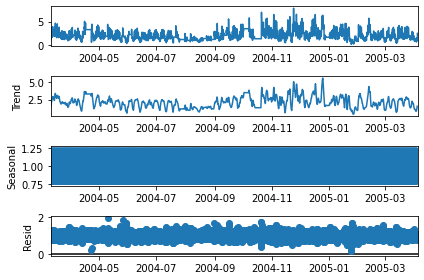

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose


analysis = df[['CO(GT)']].copy()


decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

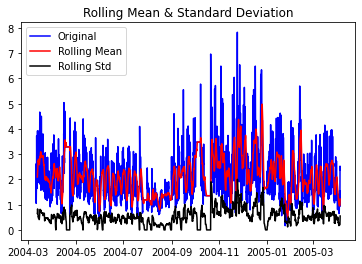

Results of Dickey Fuller Test:
Test Statistic                -9.846946e+00
p-value                        4.592785e-17
#Lags Used                     2.800000e+01
Number of Observations Used    9.328000e+03
Critical Value (1%)           -3.431051e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


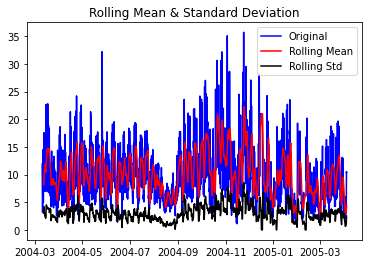

Results of Dickey Fuller Test:
Test Statistic                -1.047134e+01
p-value                        1.281952e-18
#Lags Used                     2.700000e+01
Number of Observations Used    9.329000e+03
Critical Value (1%)           -3.431051e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


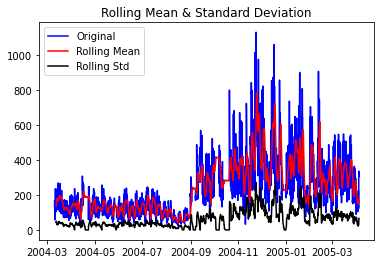

Results of Dickey Fuller Test:
Test Statistic                -6.750351e+00
p-value                        2.961936e-09
#Lags Used                     2.800000e+01
Number of Observations Used    9.328000e+03
Critical Value (1%)           -3.431051e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


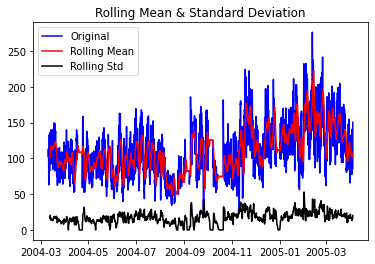

Results of Dickey Fuller Test:
Test Statistic                -7.582112e+00
p-value                        2.664973e-11
#Lags Used                     2.800000e+01
Number of Observations Used    9.328000e+03
Critical Value (1%)           -3.431051e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [10]:
columns = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
for i in columns:
    test_stationarity(df[i])

In [11]:
print('C6H6(GT) causes CO(GT)?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['CO(GT)', 'C6H6(GT)']], 5)

C6H6(GT) causes CO(GT)?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=40.6528 , p=0.0000  , df_denom=9353, df_num=1
ssr based chi2 test:   chi2=40.6659 , p=0.0000  , df=1
likelihood ratio test: chi2=40.5778 , p=0.0000  , df=1
parameter F test:         F=40.6528 , p=0.0000  , df_denom=9353, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=343.4798, p=0.0000  , df_denom=9350, df_num=2
ssr based chi2 test:   chi2=687.3269, p=0.0000  , df=2
likelihood ratio test: chi2=663.2498, p=0.0000  , df=2
parameter F test:         F=343.4798, p=0.0000  , df_denom=9350, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=285.0736, p=0.0000  , df_denom=9347, df_num=3
ssr based chi2 test:   chi2=855.8612, p=0.0000  , df=3
likelihood ratio test: chi2=818.9425, p=0.0000  , df=3
parameter F test:         F=285.0736, p=0.0000  , df_denom=9347, df_num=3

Granger Causality
number of lags (no zero) 

In [12]:
df.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH', 'hour', 'year', 'month', 'day'],
      dtype='object')

In [13]:
print('PT08.S2(NMHC) causes CO(GT)?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['CO(GT)', 'PT08.S2(NMHC)']], 5)

print('PT08.S3(NOx) causes CO(GT)?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['CO(GT)', 'PT08.S3(NOx)']], 5)

print('PT08.S4(NO2) causes CO(GT)?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['CO(GT)', 'PT08.S4(NO2)']], 5)

print('PT08.S5(O3) causes CO(GT)?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['CO(GT)', 'PT08.S5(O3)']], 5)

print('NOx(GT) causes CO(GT)?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['CO(GT)', 'NOx(GT)']], 5)

print('NO2(GT) causes CO(GT)?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['CO(GT)', 'NO2(GT)']], 5)

print('AH causes CO(GT)?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['CO(GT)', 'AH']], 5)

print('hour causes CO(GT)?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['CO(GT)', 'hour']], 5)

print('year causes CO(GT)?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['CO(GT)', 'year']], 5)

print('month causes CO(GT)?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['CO(GT)', 'month']], 5)

print('day causes CO(GT)?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['CO(GT)', 'day']], 5)

PT08.S2(NMHC) causes CO(GT)?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=28.0793 , p=0.0000  , df_denom=9353, df_num=1
ssr based chi2 test:   chi2=28.0884 , p=0.0000  , df=1
likelihood ratio test: chi2=28.0463 , p=0.0000  , df=1
parameter F test:         F=28.0793 , p=0.0000  , df_denom=9353, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=413.3252, p=0.0000  , df_denom=9350, df_num=2
ssr based chi2 test:   chi2=827.0924, p=0.0000  , df=2
likelihood ratio test: chi2=792.5516, p=0.0000  , df=2
parameter F test:         F=413.3252, p=0.0000  , df_denom=9350, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=368.2770, p=0.0000  , df_denom=9347, df_num=3
ssr based chi2 test:   chi2=1105.6584, p=0.0000  , df=3
likelihood ratio test: chi2=1045.0451, p=0.0000  , df=3
parameter F test:         F=368.2770, p=0.0000  , df_denom=9347, df_num=3

Granger Causality
number of lags (no

In [14]:
ddf = df[['CO(GT)','C6H6(GT)']]
print(ddf.shape)

(9357, 2)


In [15]:
for column in ddf.columns:
    print(ddf[column].dtype)

float64
float64


In [16]:
for column in df.columns:
    print(df[column].dtype)

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
object
int64
int64
int64


In [17]:
train_df=ddf[:-720]
test_df=ddf[-720:]

In [18]:
model = VAR(train_df[1:])
sorted_order=model.select_order(maxlags=70)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        2.131       2.132       8.421       2.131
1       -4.029      -4.024     0.01779      -4.027
2       -4.796      -4.787    0.008266      -4.793
3       -4.816      -4.805    0.008096      -4.812
4       -4.818      -4.803    0.008086      -4.813
5       -4.818      -4.800    0.008079      -4.812
6       -4.821      -4.799    0.008061      -4.813
7       -4.827      -4.802    0.008010      -4.819
8       -4.830      -4.802    0.007990      -4.820
9       -4.834      -4.803    0.007952      -4.824
10      -4.838      -4.803    0.007925      -4.826
11      -4.840      -4.802    0.007906      -4.827
12      -4.842      -4.801    0.007892      -4.828
13      -4.843      -4.798    0.007885      -4.828
14      -4.850      -4.803    0.007825      -4.834
15      -4.855      -4.804    0.007793      -4.837
16      -4.866      -4.812    0

In [19]:
var_model = VARMAX(train_df, order=(50,0),enforce_stationarity= False)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                             Statespace Model Results                             
Dep. Variable:     ['CO(GT)', 'C6H6(GT)']   No. Observations:                 8637
Model:                            VAR(50)   Log Likelihood               -2301.514
                              + intercept   AIC                           5013.028
Date:                    Thu, 18 Aug 2022   BIC                           6461.110
Time:                            14:36:16   HQIC                          5506.787
Sample:                        03-10-2004                                         
                             - 03-05-2005                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.00, 0.00   Jarque-Bera (JB):   3156777.97, 5896244.51
Prob(Q):                        0.99, 0.98   Prob(JB):                       0.00, 0.00
Heteroskedasticity (H):         0.73, 0.70   Skew:                           

In [20]:
n_forecast = 720
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)

predictions=predict.predicted_mean

In [21]:
predictions.columns=['CO(GT)','C6H6(GT)']
predictions

,CO(GT),C6H6(GT)
2005-03-05 15:00:00,1.787059,6.723808
2005-03-05 16:00:00,1.916234,7.200391
2005-03-05 17:00:00,2.035959,7.651510
2005-03-05 18:00:00,2.187312,8.303604
2005-03-05 19:00:00,2.350474,8.936277
...,...,...
2005-04-04 10:00:00,2.141615,10.266888
2005-04-04 11:00:00,2.141524,10.266530
2005-04-04 12:00:00,2.141442,10.266198
2005-04-04 13:00:00,2.141391,10.266016


In [24]:
y_true, y_pred = np.array(test_df['CO(GT)']), np.array(predictions['CO(GT)'])
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(mape)

49.08080520777915


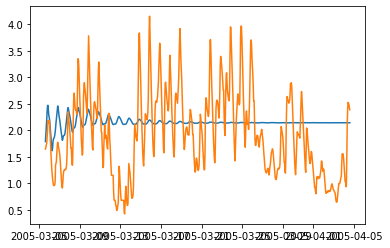

In [25]:

  plt.plot(predictions['CO(GT)'])
  plt.plot(test_df['CO(GT)'])